# ESS electives report

## Setup and Data Loading

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataframe using the correct file name
file_path = 'data/ESS_electives_op_DEC2025.csv'
df = pd.read_csv(file_path)
print(f"Data Loaded. Shape: {df.shape}")

# Define output directory
OUTPUT_DIR = 'output'
    # Create the folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory set to: {os.path.abspath(OUTPUT_DIR)}")

# In Qualtrics exports:
# Row 0 = Column Headers (Q1, Q2...) -> df.columns
# Row 1 = Question Text ("How difficult was...") -> df.iloc[0]
# Row 2 = Import IDs -> df.iloc[1]
# Row 3+ = Actual Data -> df.iloc[2:]

questions_row = df.iloc[0]
print("Header and Question Text rows identified.")

Data Loaded. Shape: (100, 187)
Output directory set to: /Users/stefanograziosi/Documents/GitHub/ESS_electives_report/output
Header and Question Text rows identified.


## Column Mapping

In [5]:
def extract_course_info(question_text):
    """
    Parses question text to extract Course Name and Category.
    """
    if not isinstance(question_text, str):
        return None, None
    
    course_name = None
    category = None
    
    # Pattern 1: "... questions below about <Course>? - <Question>"
    match_about = re.search(r"about\s+(.*?)\?\s+-(.*)", question_text)
    
    # Pattern 2: "Would you enrol in <Course> again?"
    match_enrol = re.search(r"Would you enrol in\s+(.*?)(?: again)?\??$", question_text, re.IGNORECASE)
    
    # Pattern 3: "When did you sit the exam for <Course>?"
    match_session = re.search(r"sit the exam for\s+(.*?)\??$", question_text, re.IGNORECASE)

    if match_about:
        course_name = match_about.group(1).strip()
        sub_text = match_about.group(2).strip()
        
        if "difficult was the course" in sub_text or "hard was the course" in sub_text:
            category = "Course Difficulty"
        elif "difficult was the exam" in sub_text or "hard was the exam" in sub_text:
            category = "Exam Difficulty"
        elif "in line with what has been explained" in sub_text:
            category = "Exam Alignment"
            
    elif match_enrol:
        course_name = match_enrol.group(1).strip()
        category = "Enrol Again"
        
    elif match_session:
        course_name = match_session.group(1).strip()
        category = "Exam Session"

    return course_name, category

# Build the map
course_map = {}
for col in df.columns:
    # Skip metadata columns
    if col in ['StartDate', 'EndDate', 'ResponseId', 'Q1']: continue
        
    q_text = questions_row[col]
    course, cat = extract_course_info(q_text)
    
    if course and cat:
        if course not in course_map:
            course_map[course] = {}
        course_map[course][cat] = col

print(f"Successfully mapped {len(course_map)} courses.")

Successfully mapped 31 courses.


## Data Transformation

In [7]:
# Mappings for converting text to numbers
diff_map = {
    'Easy': 1,
    'Somewhat easy': 2,
    'Neither easy nor difficult': 3,
    'Somewhat difficult': 4,
    'Difficult': 5,
    # Handle numeric strings if they appear
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}

agree_map = {
    'Strongly disagree': 5,
    'Somewhat disagree': 4,
    'Neither agree nor disagree': 3,
    'Somewhat agree': 2,
    'Strongly agree': 1
}

records = []
# Start reading data from index 2 (skipping Question Text and Import ID rows)
data_rows = df.iloc[2:]

for idx, row in data_rows.iterrows():
    respondent_id = row['ResponseId']
    
    for course, cols in course_map.items():
        # Check if the student took this course (Difficulty column is not empty)
        c_diff_col = cols.get('Course Difficulty')
        
        if c_diff_col and pd.notna(row[c_diff_col]):
            # Get raw text values
            raw_c_diff = row.get(cols.get('Course Difficulty'))
            raw_e_diff = row.get(cols.get('Exam Difficulty'))
            raw_align  = row.get(cols.get('Exam Alignment'))
            raw_enrol  = row.get(cols.get('Enrol Again'))
            
            rec = {
                'RespondentId': respondent_id,
                'Course': course,
                'Course Difficulty': diff_map.get(raw_c_diff),
                'Exam Difficulty': diff_map.get(raw_e_diff),
                'Exam Alignment': agree_map.get(raw_align),
                'Enrol Again Text': raw_enrol
            }
            
            # Convert Enrolment to 0/1
            if isinstance(raw_enrol, str) and 'Yes' in raw_enrol:
                rec['Enrol Again'] = 1
            else:
                rec['Enrol Again'] = 0
                
            records.append(rec)

long_df = pd.DataFrame(records)
print(f"Processed {len(long_df)} feedback records.")
long_df.head()

Processed 350 feedback records.


,RespondentId,Course,Course Difficulty,Exam Difficulty,Exam Alignment,Enrol Again Text,Enrol Again
0,R_2Uby8w29FHmnnoN,Advanced Microeconomics,5,4.0,NaN,"No, but I would enrol in the second year",0
1,R_2pYgmWKvuuhnxrP,Advanced Microeconomics,4,3.0,NaN,"Yes, I would enrol again",1
2,R_8hR1FMyoeDEWzA7,Advanced Microeconomics,5,5.0,5.0,"No, I would not enrol in the course at all",0
3,R_8hR1FMyoeDEWzA7,Development Economics,3,3.0,1.0,"Yes, I would enrol again",1
4,R_8hR1FMyoeDEWzA7,Labour Economics,4,4.0,4.0,"No, I would not enrol in the course at all",0


## Analysis and visualisation

In [11]:
# Calculate Summary Statistics
summary = long_df.groupby('Course').agg(
    Responses=('RespondentId', 'count'),
    Avg_Course_Difficulty=('Course Difficulty', 'mean'),
    Avg_Exam_Difficulty=('Exam Difficulty', 'mean'),
    Avg_Exam_Alignment=('Exam Alignment', 'mean'),
    Enrol_Again_Rate=('Enrol Again', 'mean')
).reset_index().sort_values('Responses', ascending=False)

# Sort by popularity
summary = summary.sort_values('Responses', ascending=False)

# Display Summary
print(summary.round(2).to_markdown(index=False))

# --- PLOTTING ---
sns.set(style="whitegrid")

# --- SAVE DATA ---
# Construct the path: output/summary_table.csv
csv_path = os.path.join(OUTPUT_DIR, 'summary_table.csv')
summary.to_csv(csv_path, index=False)
print(f"Saved summary to: {csv_path}")

| Course                                                              |   Responses |   Avg_Course_Difficulty |   Avg_Exam_Difficulty |   Avg_Exam_Alignment |   Enrol_Again_Rate |
|:--------------------------------------------------------------------|------------:|------------------------:|----------------------:|---------------------:|-------------------:|
| Microeconometrics                                                   |          57 |                    3.77 |                  4.04 |                 2.61 |               0.96 |
| Foundation of Social Sciences - Module II A                         |          45 |                    2.16 |                  2.23 |                 2.18 |               0.78 |
| Foundation of Social Sciences - Module II B                         |          32 |                    2.28 |                  2.68 |                 2.03 |               0.91 |
| Time Series Analysis of Economic and Financial Data                 |          23 |               

### Plot 1: Difficulty Comparison

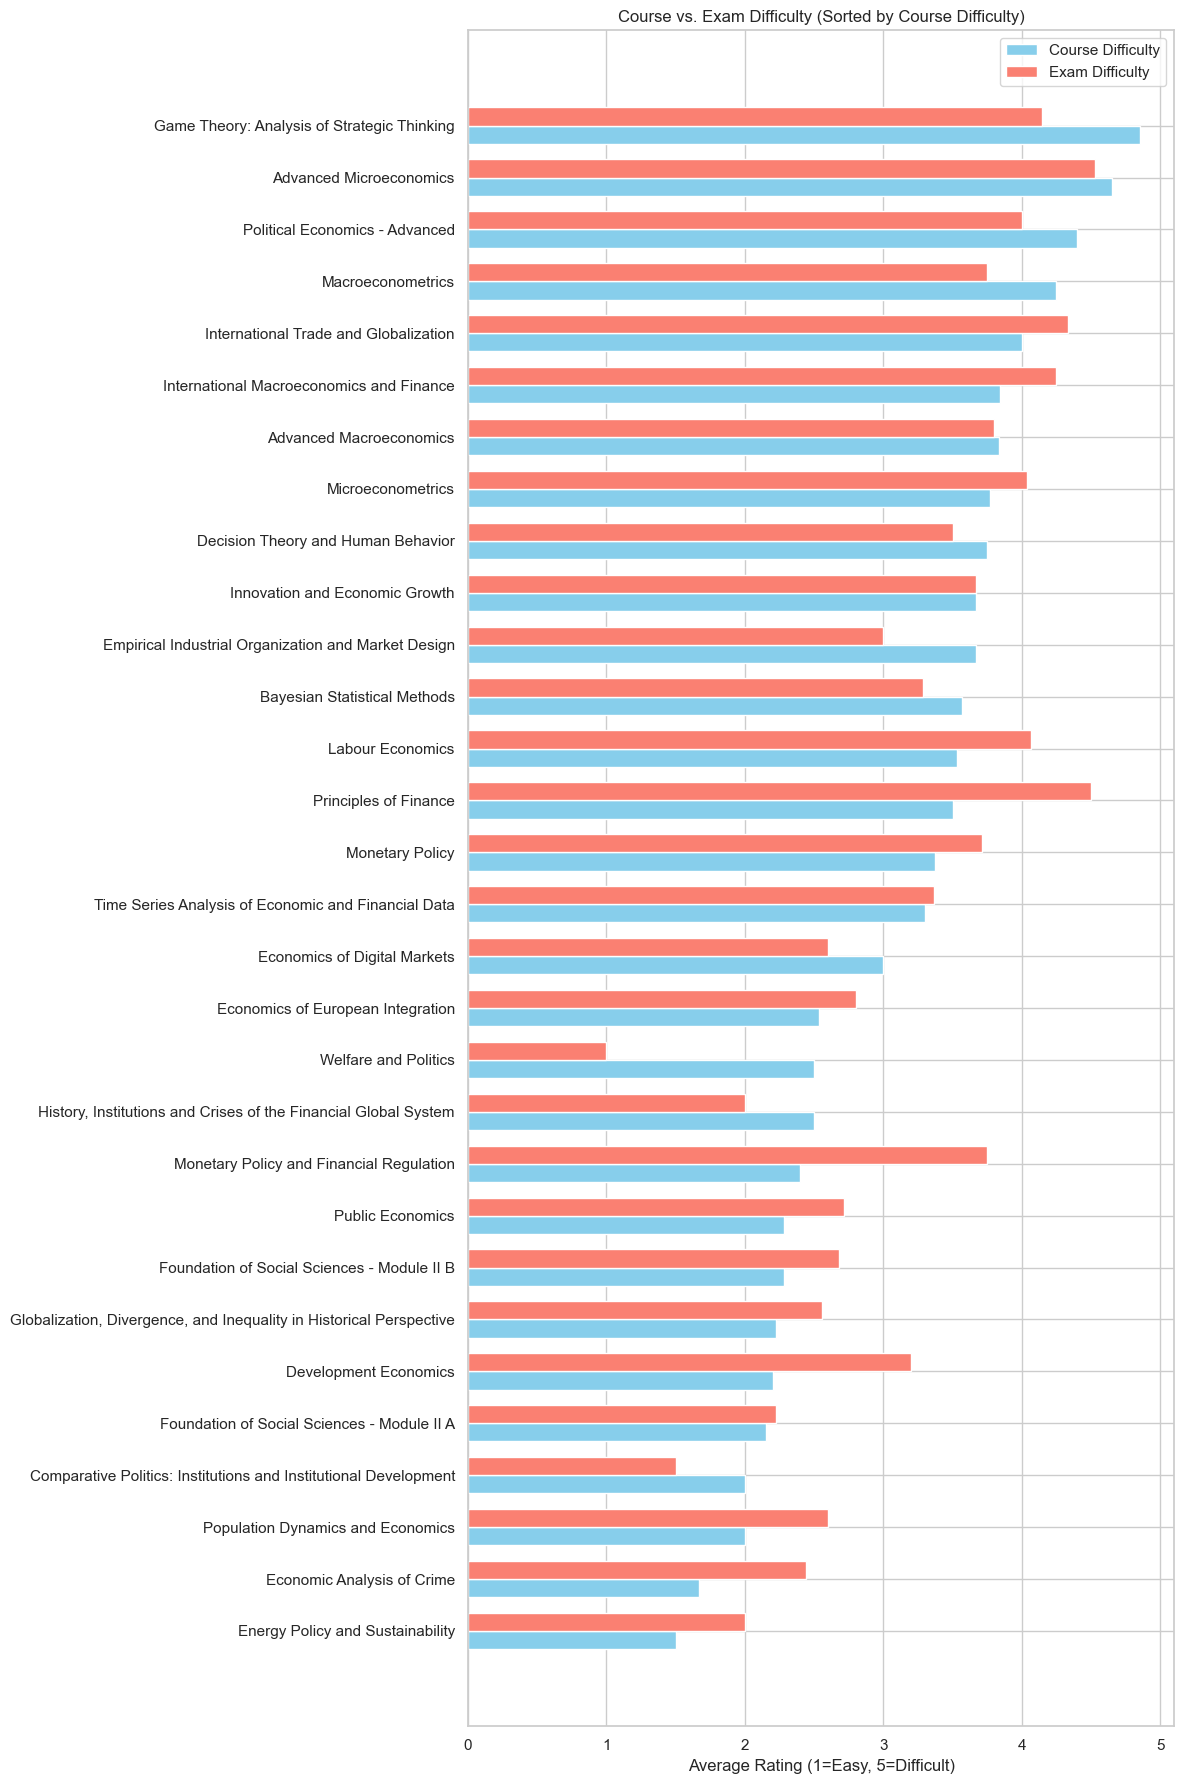

Saved plot to: output/difficulty_comparison.png


<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(12, len(summary)*0.6)) # Adjust height based on number of courses
plot_data = summary.sort_values('Avg_Course_Difficulty', ascending=True)

y_pos = np.arange(len(plot_data))
height = 0.35

plt.barh(y_pos - height/2, plot_data['Avg_Course_Difficulty'], height, label='Course Difficulty', color='skyblue')
plt.barh(y_pos + height/2, plot_data['Avg_Exam_Difficulty'], height, label='Exam Difficulty', color='salmon')

plt.yticks(y_pos, plot_data['Course'])
plt.xlabel('Average Rating (1=Easy, 5=Difficult)')
plt.title('Course vs. Exam Difficulty (Sorted by Course Difficulty)')
plt.legend()
plt.tight_layout()
plt.show()

# Save Plot 1
plot1_path = os.path.join(OUTPUT_DIR, 'difficulty_comparison.png')
plt.savefig(plot1_path)
print(f"Saved plot to: {plot1_path}")
plt.show()

### Plot 2: Heatmap of Metrics

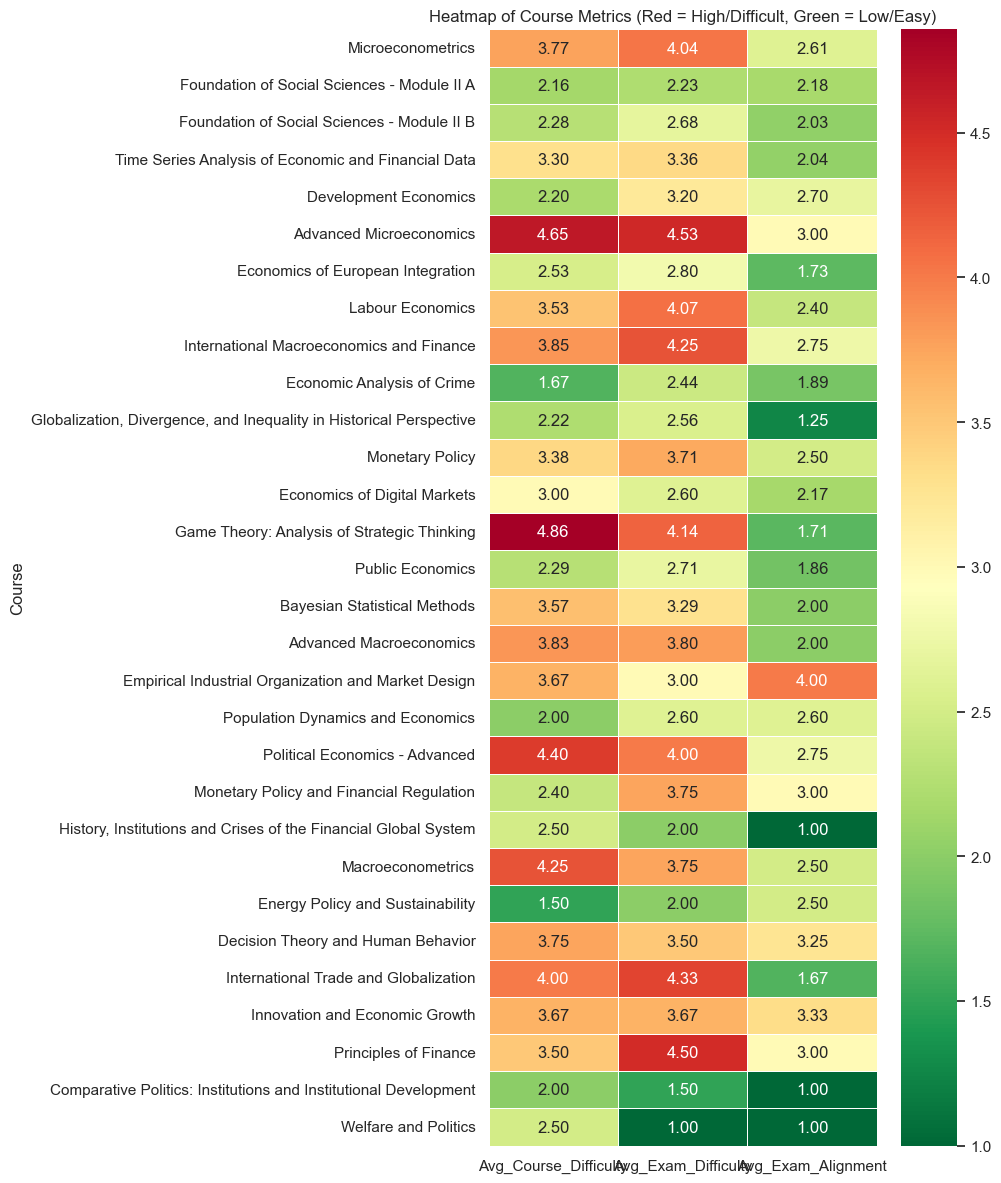

Saved plot to: output/heatmap_metrics.png


<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(10, 12))
heatmap_data = summary.set_index('Course')[['Avg_Course_Difficulty', 'Avg_Exam_Difficulty', 'Avg_Exam_Alignment']]
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Course Metrics (Red = High/Difficult, Green = Low/Easy)')
plt.tight_layout()
plt.show()

# Save Plot 2
plot2_path = os.path.join(OUTPUT_DIR, 'heatmap_metrics.png')
plt.savefig(plot2_path)
print(f"Saved plot to: {plot2_path}")
plt.show()